In [87]:
from pyofss import Domain, System, Gaussian, Fibre, Filter, Splitter, FibrePlotter, Noise
from pyofss import temporal_power, spectral_power, lambda_to_nu, nu_to_lambda, multi_plot, single_plot, labels
from pyofss.field import energy, max_peak_params, spectrum_width_params
import numpy as np
import matplotlib as mpl
import matplotlib
mpl.rcParams['agg.path.chunksize'] = 10000
import pylab as plt
plt.switch_backend('agg')
from scipy.signal import find_peaks
import time
%matplotlib inline
from pyofss.modules.nonlinearity import calculate_gamma
from pyofss.domain import lambda_to_omega
import os.path

def check_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Directory: ", dir, " is created!")


In [19]:
F1 = lambda_to_nu(1040) - lambda_to_nu(1035)
F2 = (lambda_to_nu(1030) - lambda_to_nu(1035))
FW1 = (Domain.vacuum_light_speed/(1040**2))*4
FW2 = (Domain.vacuum_light_speed/(1030**2))*4
C1 = 0.4
C2 = 0.9
E1 = 9.15
E2 = 36.6
L3 = 0.8
L6 = 0.8
SSG = 10
G1 = calculate_gamma(2.7*(10**(-20)), 37.8, lambda_to_omega(1035))
G2 = calculate_gamma(2.7*(10**(-20)), 29, lambda_to_omega(1035))
N = 7
N_cycles = 1
Pp_0 = 10

Esat_1 = E1                     # 9.15nJ
Esat_2 = E2                   # 36.6nJ
La_1 = 2.5*1e-3                  # 2.5m
La_2 = 2.5*1e-3                  # 2.5m
Lp_1 = 0.8*1e-3                                 # 0.8m
Lp_2 = L3*1e-3                                 # 0.8m
Lp_3 = 0.8*1e-3                                 # 0.8m
Lp_4 = L6*1e-3                                 # 0.8m
Lr = La_1 + La_2 + Lp_1 + Lp_2 + Lp_3 + Lp_4
Tr = Lr * 1e12 / Domain.vacuum_light_speed # ps
gamma_passive = G1
gamma_active = G2
small_signal_gain = SSG

local_error = 0.000001
step_size = 0.0000001

useRaman = True
useAdaptive = False
use_Yb_model = False
use_noise = False
noise_scale = 0.0000001

Dir = "C:/Users/User1/Programs/examples/resultsMamyshev/"

In [20]:
useRamanName = ""
useAdaptiveName = ""
if useRaman:
    use_all = "hollenbeck"
    useRamanName = "rmn"
    print(f"use raman gain")
else: 
    use_all = False
    useRamanName = "no_rmn"
    print(f"DO NOT use raman gain")

if useAdaptive:
    method='ass_symmetric'
    useAdaptiveName = "as"
    print(f"use adaptive stepper")
else: 
    method='ss_symmetric'
    useAdaptiveName = "ss"
    print(f"DO NOT use adaptive stepper")

if use_Yb_model:
    useYbModelName = "ybm"
    print(f"use Yb amplification model")
else: 
    useYbModelName = "sm"
    print(f"use simple amplification model")

if use_noise:
    useNoiseName = "ns"
    print(f"use noise at the end of each amplification fibre")
else: 
    useNoiseName = "no_ns"
    print(f"no noise in model")

folder_name = f"{useRamanName}_{useYbModelName}_{useNoiseName}_{useAdaptiveName}_{F1:.2f}_F2_{F2:.2f}_FW1_{FW1:.2f}_FW2_{FW2:.2f}_C1_{C1:.2f}_C2_{C2:.2f}_E1_{E1:.2f}_E2_{E2:.2f}_L3_{L3:.2f}_L6_{L6:.2f}_SSG_{SSG:.2f}_N_{N:.2f}_Pp_{Pp_0:.2f}_G1_{G1:.2f}_G2_{G2:.2f}_Nc_{N_cycles}_LE_{local_error}_SS_{step_size}_NS_{noise_scale}"
RootDir = os.path.join(
    Dir, folder_name)
check_dir(RootDir)
graph_dir = os.path.join(RootDir, "graph")
check_dir(graph_dir)

use raman gain
DO NOT use adaptive stepper
use simple amplification model
no noise in model
Directory:  C:/Users/User1/Programs/examples/resultsMamyshev/rmn_sm_no_ns_ss_-1.39_F2_1.41_FW1_1.11_FW2_1.13_C1_0.40_C2_0.90_E1_9.15_E2_36.60_L3_0.80_L6_0.80_SSG_10.00_N_7.00_Pp_10.00_G1_4.34_G2_5.65_Nc_1_LE_1e-06_SS_1e-07_NS_1e-07  is created!
Directory:  C:/Users/User1/Programs/examples/resultsMamyshev/rmn_sm_no_ns_ss_-1.39_F2_1.41_FW1_1.11_FW2_1.13_C1_0.40_C2_0.90_E1_9.15_E2_36.60_L3_0.80_L6_0.80_SSG_10.00_N_7.00_Pp_10.00_G1_4.34_G2_5.65_Nc_1_LE_1e-06_SS_1e-07_NS_1e-07\graph  is created!


In [21]:
peak_power = 1000.
peak_width = 10.
peak_C = 300.

domain = Domain(samples_per_bit=2**15, bit_width=400.0,
                total_bits=1, centre_nu=lambda_to_nu(1035))

gaussian = Gaussian(name="initial_pulse", peak_power=peak_power,
                    width=peak_width, C=peak_C, using_fwhm=True)
A = gaussian.generate(domain.t)
E = energy(A, domain.t)

In [23]:
sys = System(domain, A, charact_dir=os.path.join(Dir, f'cycle_current'))

for i in range(N_cycles):
    # cycleDir = os.path.join(Dir, f'cycle{int(i)}')
    cycleDir = os.path.join(Dir, f'cycle_current')
    sys.add(Filter(name="filter_1", width_nu=(FW1), offset_nu=(F1),
                m=1, channel=0, using_fwhm=True, type_filt="reflected"))
    sys.add(Fibre(name="1_passive_fibre", length=Lp_1, gamma=gamma_passive, beta=np.array(
        [0, 0, 22.2]), total_steps=int(Lp_1/step_size), traces=100, local_error=local_error, use_all=use_all, method=method, cycle=f'cycle{int(i)}', save_represent="complex"))
    sys.add(Fibre(name="2_active_fibre", length=La_1, gamma=gamma_active, beta=np.array(
        [0, 0, 24.9]), total_steps=int(La_1/step_size), traces=100, local_error=local_error, use_all=use_all, method=method, cycle=f'cycle{int(i)}', small_signal_gain=small_signal_gain, E_sat=Esat_1, lamb0=1035., bandwidth=40., use_Yb_model=use_Yb_model, Pp_0=Pp_0, Rr=1/Tr, N=N, save_represent="complex"))
    if use_noise:
        sys.add(Noise(name="gaussian_noise", disp_factor=noise_scale))
    sys.add(Fibre(name="3_passive_fibre", length=Lp_2, gamma=gamma_passive, beta=np.array(
        [0, 0, 22.2]), total_steps=int(Lp_2/step_size), traces=100, local_error=local_error, use_all=use_all, method=method, cycle=f'cycle{int(i)}', save_represent="complex"))
    sys.add(Splitter(name="splitter", loss=C1))
    sys.add(Filter(name="filter_2", width_nu=(FW2), offset_nu=(F2),
                m=1, channel=0, using_fwhm=True, type_filt="reflected"))
    sys.add(Fibre(name="4_passive_fibre", length=Lp_3, gamma=gamma_passive, beta=np.array(
        [0, 0, 22.2]),  total_steps=int(Lp_3/step_size), traces=100, local_error=local_error, use_all=use_all, method=method, cycle=f'cycle{int(i)}', save_represent="complex"))
    sys.add(Fibre(name="5_active_fibre", length=La_2, gamma=gamma_active, beta=np.array(
        [0, 0, 24.9]), total_steps=int(La_2/step_size), traces=100, local_error=local_error, use_all=use_all, method=method, cycle=f'cycle{int(i)}', small_signal_gain=small_signal_gain, E_sat=Esat_2, lamb0=1035., bandwidth=40., use_Yb_model=use_Yb_model, Pp_0=Pp_0, Rr=1/Tr, N=N, save_represent="complex"))
    if use_noise:
        sys.add(Noise(name="gaussian_noise", disp_factor=noise_scale))
    sys.add(Fibre(name="6_passive_fibre", length=Lp_4, gamma=gamma_passive, beta=np.array(
        [0, 0, 22.2]), total_steps=int(Lp_4/step_size), traces=100, local_error=local_error, use_all=use_all, method=method, cycle=f'cycle{int(i)}', save_represent="complex"))
    sys.add(Splitter(name="splitter", loss=C2))  # use from sh script
sys.run()

Directory is empty
Using general expression for nonlinearity
amplifier length equals 0.0025
YDF lanmbda = 1035.0 nm
YDF bandwidth = 40.0 nm
Using general expression for nonlinearity
Using general expression for nonlinearity
Using general expression for nonlinearity
amplifier length equals 0.0025
YDF lanmbda = 1035.0 nm
YDF bandwidth = 40.0 nm
Using general expression for nonlinearity
Using general expression for nonlinearity
Caching linear factor


c:\Users\User1\Programs\examples\pyofss\modules\nonlinearity.py:218: RuntimeWarning: invalid value encountered in true_divide
  term_ss_all = np.where(np.abs(B) > 1e-15, self.ss_factor / B, 0.0) * ifft(self.omega * fft(term_all * A))
c:\Users\User1\Programs\examples\pyofss\modules\storage.py:225: UserWarning: Nothing will be saved - base fibre directory is not stated!
  warnings.warn("Nothing will be saved - base fibre directory is not stated!")


Caching linear factor
Caching linear factor
Caching linear factor
Caching linear factor
Caching linear factor


In [24]:
sys.init_df("temp")
# sys1.df_type_dict["temp"]

In [25]:
sys.df_type_dict["temp"]

0             1             2      \
cycle  fibre           z [mm]                                             
cycle0 1_passive_fibre 0.1     1.972152e-31  4.930381e-31  1.429810e-30   
                       8.1     8.409750e-28  1.012158e-27  2.423775e-28   
                       16.1    4.633029e-27  3.062555e-27  1.809055e-27   
                       24.1    8.697241e-27  8.584877e-27  5.079525e-27   
                       32.1    2.177118e-26  1.201894e-26  1.153359e-26   
...                                     ...           ...           ...   
       6_passive_fibre 8086.6  1.760941e-21  1.611058e-21  1.473215e-21   
                       8094.6  1.807960e-21  1.634032e-21  1.480914e-21   
                       8102.6  1.823793e-21  1.673592e-21  1.500130e-21   
                       8110.6  1.849439e-21  1.668543e-21  1.542877e-21   
                       8118.6  1.843758e-21  1.688397e-21  1.555923e-21   

                                      3             4             5      \
cycle  fibre           z [mm]                                             
cycle0 1_passive_fibre 0.1     1.972152e-31  7.888609e-31  2.465190e-31   
                       8.1     7.518831e-29  7.651951e-29  4.102077e-29   
                       16.1    6.575649e-28  1.530390e-28  6.652070e-28   
                       24.1    2.558522e-27  1.668934e-28  1.516289e-27   
                       32.1    4.646588e-27  6.611640e-28  2.245493e-27   
...                                     ...           ...           ...   
       6_passive_fibre 8086.6  1.345302e-21  1.201685e-21  1.121486e-21   
                       8094.6  1.344271e-21  1.239609e-21  1.131888e-21   
                       8102.6  1.347851e-21  1.258529e-21  1.148128e-21   
                       8110.6  1.372879e-21  1.256476e-21  1.165701e-21   
                       8118.6  1.413680e-21  1.271047e-21  1.170987e-21   

                                      6             7             8      \
cycle  fibre           z [mm]                                             
cycle0 1_passive_fibre 0.1     6.409495e-31  4.437343e-31  1.972152e-30   
                       8.1     4.961935e-28  2.179228e-28  1.642803e-28   
                       16.1    5.112312e-28  1.548633e-28  8.687331e-28   
                       24.1    2.770874e-28  2.884273e-29  2.404941e-27   
                       32.1    1.329674e-27  1.196801e-27  3.480306e-27   
...                                     ...           ...           ...   
       6_passive_fibre 8086.6  1.054298e-21  1.000494e-21  9.758669e-22   
                       8094.6  1.058097e-21  1.008507e-21  9.839586e-22   
                       8102.6  1.085064e-21  9.919258e-22  1.005172e-21   
                       8110.6  1.089446e-21  1.028691e-21  9.862942e-22   
                       8118.6  1.099963e-21  1.055688e-21  9.786866e-22   

                                      9      ...         32758         32759  \
cycle  fibre           z [mm]                ...                               
cycle0 1_passive_fibre 0.1     9.860761e-31  ...  1.306551e-29  1.089614e-29   
                       8.1     7.518831e-28  ...  2.419067e-26  1.275435e-26   
                       16.1    2.699876e-27  ...  9.405870e-26  6.940423e-26   
                       24.1    6.316459e-27  ...  1.763009e-25  1.526229e-25   
                       32.1    1.085127e-26  ...  3.077656e-25  2.639034e-25   
...                                     ...  ...           ...           ...   
       6_passive_fibre 8086.6  9.919125e-22  ...  4.608558e-21  4.407133e-21   
                       8094.6  9.794236e-22  ...  4.640594e-21  4.497401e-21   
                       8102.6  9.818192e-22  ...  4.683627e-21  4.496799e-21   
                       8110.6  9.795517e-22  ...  4.791472e-21  4.577365e-21   
                       8118.6  9.848652e-22  ...  4.827068e-21  4.639829e-21   

                                      32760         32761         327

In [26]:
sys.df_results

max_value    energy  duration  spec_width  \
cycle  fibre           z [mm]                                               
cycle0 1_passive_fibre 0.1     874.874107  0.861723  0.925323    1.105033   
                       8.1     873.846824  0.861723  0.926424    1.121264   
                       16.1    872.778055  0.861723  0.927575    1.137996   
                       24.1    871.668231  0.861723  0.928776    1.155233   
                       32.1    870.517810  0.861723  0.930048    1.172973   
...                                   ...       ...       ...         ...   
       6_passive_fibre 8086.6  899.951301  2.714711  3.336857    5.987500   
                       8094.6  897.851203  2.714711  3.344014    5.990000   
                       8102.6  895.758594  2.714711  3.351071    5.995000   
                       8110.6  893.679824  2.714711  3.358155    6.000000   
                       8118.6  891.607902  2.714711  3.365254    6.005000   

                                 peaks  
cycle  fibre           z [mm]           
cycle0 1_passive_fibre 0.1     [16298]  
                       8.1     [16298]  
                       16.1    [16298]  
                       24.1    [16298]  
                       32.1    [16298]  
...                                ...  
       6_passive_fibre 8086.6  [16394]  
                       8094.6  [16394]  
                       8102.6  [16395]  
                       8110.6  [16395]  
                       8118.6  [16395]  

[600 rows x 5 columns]

In [85]:
cycle_names = list(set(sys.df_type_dict["temp"].index.get_level_values('cycle').values))
cycle_names.sort()
cycle_df = sys.df_type_dict["temp"].loc[cycle_names[0]]
fibre_names = list(set(cycle_df.index.get_level_values('fibre').values))
fibre_names.sort()
max_value = sys.df_type_dict["temp"].values.max()
min_value = sys.df_type_dict["temp"].values.min()
print("fibre_names:", fibre_names)
print("cycle_names:", cycle_names)

fibre_names: ['1_passive_fibre', '2_active_fibre', '3_passive_fibre', '4_passive_fibre', '5_active_fibre', '6_passive_fibre']
cycle_names: ['cycle0']


In [81]:
(len(cycle_names), len(fibre_names))

(1, 6)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


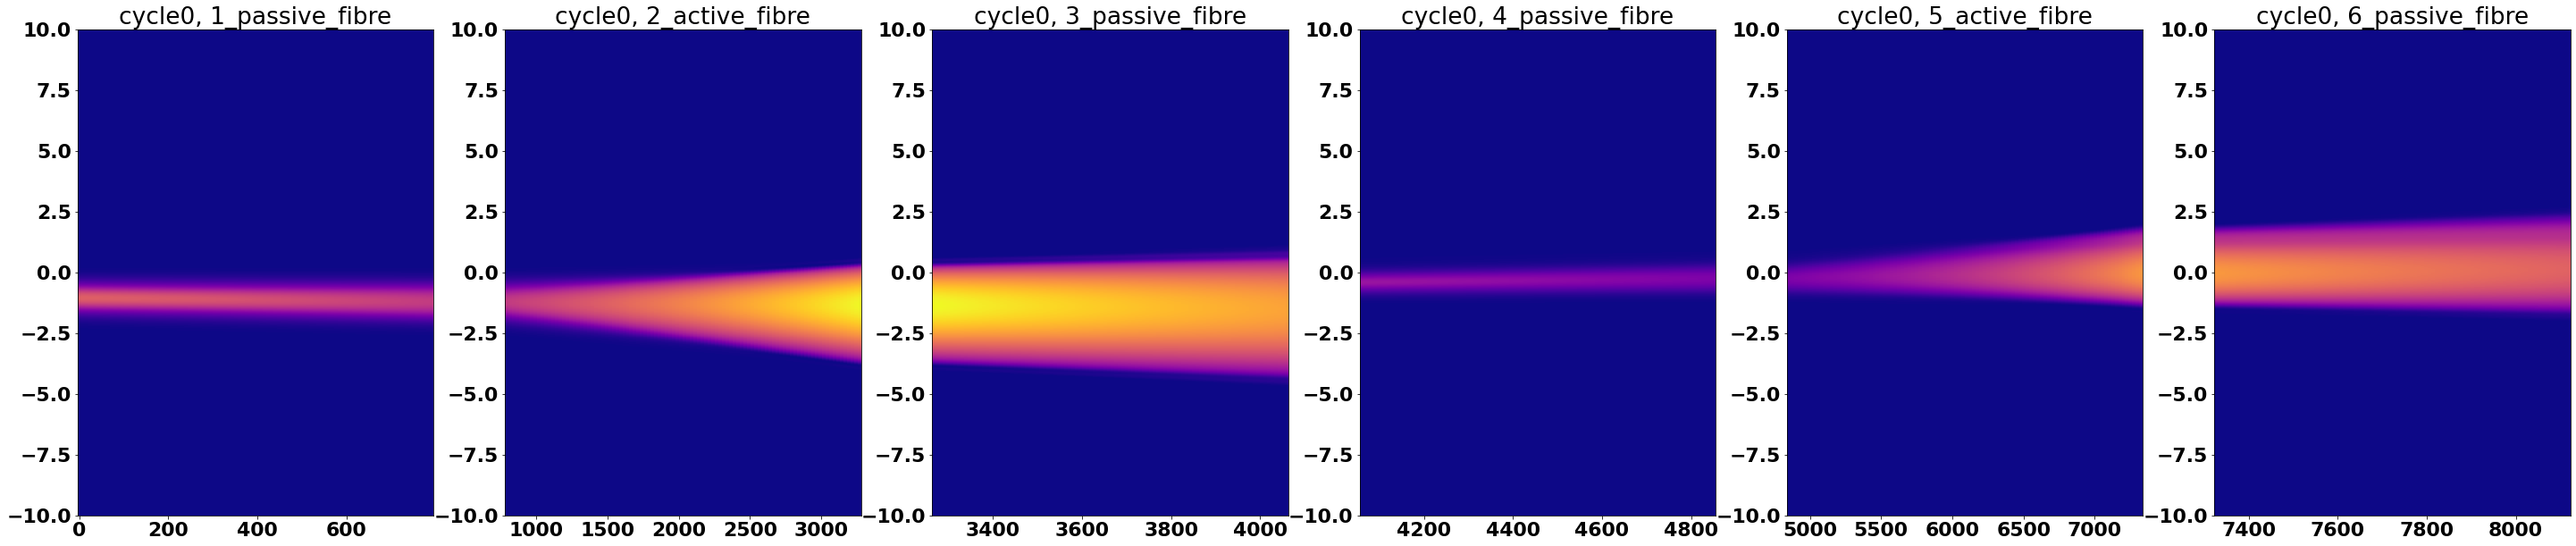

In [88]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(nrows=len(cycle_names), ncols=len(fibre_names), figsize=(50, 10))
x = domain.t
for i, cycle_name in enumerate(cycle_names):
    cycle_df = sys.df_type_dict["temp"].loc[cycle_name]
    fibre_names = list(set(cycle_df.index.get_level_values('fibre').values))
    fibre_names.sort()
    for j, fibre_name in enumerate(fibre_names):
        fibre_df =  sys.df_type_dict["temp"].loc[cycle_name].loc[fibre_name]
        z = fibre_df.index.get_level_values('z [mm]').values
        X, Y = np.meshgrid(z, x)
        h = fibre_df.values.transpose()
        cf = ax[j].pcolormesh(X, Y, h, shading='auto', cmap=plt.cm.get_cmap('plasma'), vmin=min_value, vmax=max_value)
        ax[j].set_ylim(-10, 10)
        ax[j].set_title(f"{cycle_name}, {fibre_name}")
        
        # fig.colorbar(cf, ax=ax[0])